# NLP project -Skimlit:
 **contents** 

1.   Aim of the project
2.   preparing the datasets
3.   Model-0: Baseline Model
4. Model-1: Conv1D Model

   *   preparing datasets for DL model
   *   creating coustom text embedding

5. Model-2: Feature extraction Model
6. Model-3: Conv1D with charcter embeddings
7. Model-4: Combining pretrained token Embedings+Charcter embeddings
8. Model-5 Transfer Learning token embeddins +charcter embedding+ positional embedding
      
      *   Creating positional embedding
      *   Building the embedded model

9. Model-6: Coustom Token embedded Conv1d+char embedding+ Positional embedding
10. Comparing all the Model results
11. Saving the best performing model
12. Evaluating the mdel with test data
13. Making sample predictions.

















# Aim of the project:
In this project i'm trying to replicate the deep learning model behind the 2017 paper [link text](https://arxiv.org/abs/1710.06071) with its 10% of data.
The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature,so we are creating an NLP model  to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature  and dive deeper when necessary.

In [1]:
!nvidia-smi

Wed Jan  4 12:28:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#geting the data for the project
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir='pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
#ckecking all the file names in the directory 
import os
filenames=[data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
#creating a fuction to read the line in the document 
def get_lines(filename):
  with open (filename,'r') as f:
    return f.readlines()

In [7]:
train_lines=get_lines(data_dir+'train.txt')
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
train_lines[:3]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n']

In [9]:
def preprocess_text_with_linenumber(filename):
  input_lines=get_lines(filename)
  abstract_lines=""
  abstract_samples=[]

  #loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split= abstract_lines.splitlines() # spliting abstract lines into seperate lines
      #iterate through each line and counting at the same time
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split('\t')
        line_data['target']=target_text_split[0]
        line_data['text']=target_text_split[1]
        line_data['line_number']=abstract_line_number
        line_data['total_number_of_lines']=len(abstract_line_split)-1
        abstract_samples.append(line_data)

    else:
      abstract_lines+=line

  return abstract_samples


In [10]:
train_samples = preprocess_text_with_linenumber(data_dir + "train.txt")
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_number_of_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_number_of_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_number_of_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_number_of_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outc

In [11]:
# Get data from file and preprocess it
%%time
val_samples = preprocess_text_with_linenumber(data_dir + "dev.txt") 
test_samples = preprocess_text_with_linenumber(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 147 ms, sys: 18.3 ms, total: 166 ms
Wall time: 219 ms


(180040, 30212, 30135)

In [12]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)
train_df.head(10)


,target,text,line_number,total_number_of_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [14]:
test_df.target.value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

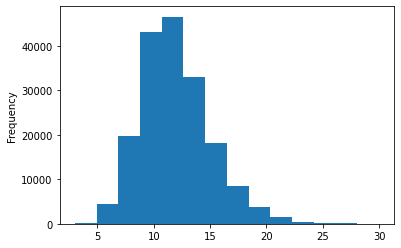

In [15]:
train_df.total_number_of_lines.plot.hist(bins=14)

In [16]:

# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

In [18]:
# one hot encoding the labels 
from sklearn.preprocessing  import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labes_one_hot=one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
#label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded=label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded=label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded[:10]


array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [20]:
#getting class names and its length
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# MODEL:0 Baseline model

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

model_0.fit(X=train_sentences,y=train_labels_encoded);

In [22]:

# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
#making predictions
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  model_accuracy=accuracy_score(y_true,y_pred)*100
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
  model_results={'accuracy': model_accuracy,
                 'precison': model_precision,
                 'recall': model_recall,
                 'f1 score':model_f1}

  return model_results

In [25]:

# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precison': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1 score': 0.6989250353450294}

##preparing datasets for DL models:

In [26]:
# importing necessary libraries for the process;
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [27]:
# finding the average sentance length 
sent_length=[len(sentance.split())for sentance in train_sentences]
avg_length=np.mean(sent_length)
avg_length

26.338269273494777

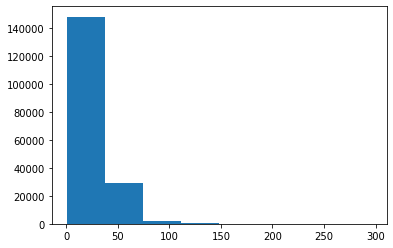

In [28]:
# finding the ditribution of the sentemce length
plt.hist(sent_length,bins=8);

In [29]:
output_seq_length=int(np.percentile(sent_length,95))
output_seq_length

55

In [30]:
max(sent_length)

296

In [31]:
#creating textvectoriser layers
max_tokens=68000 # vocabulary size of pubmed 20k

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                               output_sequence_length=55)


In [32]:


# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
import random
random_sentence=random.choice(test_sentences)
print(f'text:\n {random_sentence}')
print(f'\n length of sentence : {len(random_sentence.split())}')
print(f"\nVectorized text:\n{text_vectorizer([random_sentence])}")

text:
 HbA@c predicted incident diabetes .

 length of sentence : 5

Vectorized text:
[[ 615  830 1959  223    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:10]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-10:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in the vocabulary: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Creating a coustom text embedding

In [35]:
token_embedding=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                 output_dim=256,
                                 mask_zero=True,
                                 name='tkn_embedding')

In [36]:
# Show example embedding
print(f"Sentence before vectorization:\n{random_sentence}\n")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
HbA@c predicted incident diabetes .

Sentence after vectorization (before embedding):
[[ 615  830 1959  223    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.01543163 -0.04310838 -0.03288016 ...  0.01162178 -0.00314282
    0.00769762]
  [-0.02897182  0.00126554  0.04983903 ... -0.04222799  0.0412941
   -0.01885979]
  [-0.03601081 -0.0115069   0.0053718  ...  0.01722449 -0.03135728
   -0.04280579]
  ...
  [ 0.03784006 -0.02228273 -0.01575689 ...  0.04930656  0.00076063
    0.01381648]
  [ 0.03784006 -0.02228273 -0.01575689 ...  0.04930656  0.00076063
    0.01381648]
  [ 0.03784006 -0.02228273 -0.01575689 ...  0.04930656  0.00076063
    0.01381648]]]

Embedded sentence shape: (1, 55, 256)


In [37]:
# turining datasets into tesorflow datasets
train_datasets=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_datasets=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labes_one_hot))

train_datasets
     

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1 -conV1D

In [39]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embedding(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(x)
x=layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1=tf.keras.Model(inputs,outputs)

#compiling
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 tkn_embedding (Embedding)   (None, 55, 256)           16599296  
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            81984     
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                              

In [41]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.2 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.2 * len(valid_dataset))) 


Epoch 1/5
1125/1125 [==============================] - 24s 14ms/step - loss: 0.6952 - accuracy: 0.7353 - val_loss: 0.5381 - val_accuracy: 0.7989
Epoch 2/5
1125/1125 [==============================] - 15s 13ms/step - loss: 0.5367 - accuracy: 0.8039 - val_loss: 0.5078 - val_accuracy: 0.8064
Epoch 3/5
1125/1125 [==============================] - 15s 13ms/step - loss: 0.5307 - accuracy: 0.8050 - val_loss: 0.4828 - val_accuracy: 0.8168
Epoch 4/5
1125/1125 [==============================] - 20s 18ms/step - loss: 0.4935 - accuracy: 0.8171 - val_loss: 0.4754 - val_accuracy: 0.8242
Epoch 5/5
1125/1125 [==============================] - 17s 15ms/step - loss: 0.4907 - accuracy: 0.8214 - val_loss: 0.4789 - val_accuracy: 0.8229


In [42]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4846 - accuracy: 0.8215


[0.48460653424263, 0.8214947581291199]

In [43]:
model_1_pred_probs=model_1.predict(valid_dataset)
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [44]:
model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 82.1494770289951,
 'precison': 0.8209034686158704,
 'recall': 0.821494770289951,
 'f1 score': 0.818209239015451}

# Model-2 Feature extraction model with pretrained token embeddings

In [45]:
import tensorflow_hub as hub

In [46]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [47]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
Statistical analysis was performed using a split plot model of repeated measures analysis of variance .

Sentence after embedding:
[-0.02038876 -0.06841031  0.00275054  0.01841585 -0.01394176 -0.0487159
 -0.05845594 -0.01425251  0.04796767  0.0773197   0.01405929 -0.05945059
  0.00292387  0.05843642 -0.05823619 -0.04901077  0.06152319  0.0258544
  0.05495091 -0.01559523 -0.07581279  0.05258315 -0.0322306  -0.05134259
  0.01534721  0.05841066  0.05093497  0.0407923  -0.03701919 -0.0262456 ] (truncated output)...

Length of sentence embedding:
512


In [48]:
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained=tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation='relu')(pretrained)
x=layers.Dense(128,activation='relu')(x)

outputs=layers.Dense(num_classes,activation='softmax')(x)

model_2=tf.keras.Model(inputs,outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [49]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.2 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.2 * len(valid_dataset))) 

Epoch 1/5
1125/1125 [==============================] - 19s 14ms/step - loss: 0.8127 - accuracy: 0.6839 - val_loss: 0.7154 - val_accuracy: 0.7230
Epoch 2/5
1125/1125 [==============================] - 14s 13ms/step - loss: 0.6946 - accuracy: 0.7325 - val_loss: 0.6708 - val_accuracy: 0.7442
Epoch 3/5
1125/1125 [==============================] - 14s 13ms/step - loss: 0.6838 - accuracy: 0.7361 - val_loss: 0.6433 - val_accuracy: 0.7548
Epoch 4/5
1125/1125 [==============================] - 14s 13ms/step - loss: 0.6474 - accuracy: 0.7538 - val_loss: 0.6252 - val_accuracy: 0.7606
Epoch 5/5
1125/1125 [==============================] - 15s 13ms/step - loss: 0.6411 - accuracy: 0.7556 - val_loss: 0.6224 - val_accuracy: 0.7631


In [50]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.6276 - accuracy: 0.7590


[0.6276187300682068, 0.7590030431747437]

In [51]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred=tf.argmax(model_2_pred_probs,axis=1)
model_2_pred

945/945 [==============================] - 10s 10ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [52]:
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_pred)
model_2_results

{'accuracy': 75.90030451476235,
 'precison': 0.7538063292252908,
 'recall': 0.7590030451476235,
 'f1 score': 0.7542831584438828}

#Model 3: Conv1D with character embeddings

In [53]:
#function to split sentence into characters
def split_sen(text):
  return " ".join(list(text))


# Test splitting non-character-level sequence into characters
split_sen(random_training_sentence)

'S t a t i s t i c a l   a n a l y s i s   w a s   p e r f o r m e d   u s i n g   a   s p l i t   p l o t   m o d e l   o f   r e p e a t e d   m e a s u r e s   a n a l y s i s   o f   v a r i a n c e   .'

In [54]:
train_char=[split_sen(sentence) for sentence in train_sentences]
val_char=[split_sen(sentence) for sentence in val_sentences]
test_char=[split_sen(sentence) for sentence in test_sentences]
print(train_char[0])

T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .


In [55]:

# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

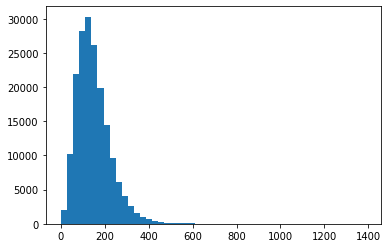

In [56]:
plt.hist(char_lens,bins=50);

In [57]:
# output sequence length
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [58]:
#getting all keyboard charcters  character level embeddings
import string
alphabets=string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
#creating  tocken vectorizer
num_char_length=len(alphabets)
char_vectorizer=TextVectorization(max_tokens=num_char_length,
                                  output_sequence_length=output_seq_char_len,
                                  standardize="lower_and_strip_punctuation",
                                  name='char_vectorizer')

In [60]:
char_vectorizer.adapt(train_char)

In [61]:

# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")
     

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Creating a character level embedding

In [62]:
char_embedding=layers.Embedding(input_dim=num_char_length,
                                output_dim=25,
                                mask_zero=False,
                                name='char_embedding')



In [63]:
#building the con!d model with char embedding.
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vect=char_vectorizer(inputs)
char_embd=char_embedding(char_vect)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(char_embd)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)

model_3=tf.keras.Model(inputs,outputs,name="model_3_conv1D_char_embedding")


# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [64]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           1700      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           20544     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                    

In [65]:
#creating the char datasets for better performance usinfg tf.data
train_char_datasets=tf.data.Dataset.from_tensor_slices((train_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets=tf.data.Dataset.from_tensor_slices((val_char,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets=tf.data.Dataset.from_tensor_slices((test_char,test_labes_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [66]:

# Fit the model on chars only
model_3_history = model_3.fit(train_char_datasets,
                              steps_per_epoch=int(0.2 * len(train_char_datasets)),
                              epochs=5,
                              validation_data=val_char_datasets,
                              validation_steps=int(0.2 * len(val_char_datasets)))

Epoch 1/5
1125/1125 [==============================] - 7s 6ms/step - loss: 1.0934 - accuracy: 0.5621 - val_loss: 0.8826 - val_accuracy: 0.6607
Epoch 2/5
1125/1125 [==============================] - 6s 6ms/step - loss: 0.8346 - accuracy: 0.6766 - val_loss: 0.7681 - val_accuracy: 0.7037
Epoch 3/5
1125/1125 [==============================] - 6s 6ms/step - loss: 0.7695 - accuracy: 0.7052 - val_loss: 0.7068 - val_accuracy: 0.7293
Epoch 4/5
1125/1125 [==============================] - 6s 6ms/step - loss: 0.7171 - accuracy: 0.7265 - val_loss: 0.6771 - val_accuracy: 0.7421
Epoch 5/5
1125/1125 [==============================] - 7s 6ms/step - loss: 0.6948 - accuracy: 0.7378 - val_loss: 0.6925 - val_accuracy: 0.7328


In [67]:
model_3.evaluate(val_char_datasets)

945/945 [==============================] - 4s 5ms/step - loss: 0.7028 - accuracy: 0.7294


[0.7028109431266785, 0.7293790578842163]

In [68]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_datasets)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

945/945 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [69]:

#Conv1D char only model results
model_3_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_preds)
model_3_results


{'accuracy': 72.93790546802596,
 'precison': 0.7325282702116884,
 'recall': 0.7293790546802595,
 'f1 score': 0.7225810987280227}

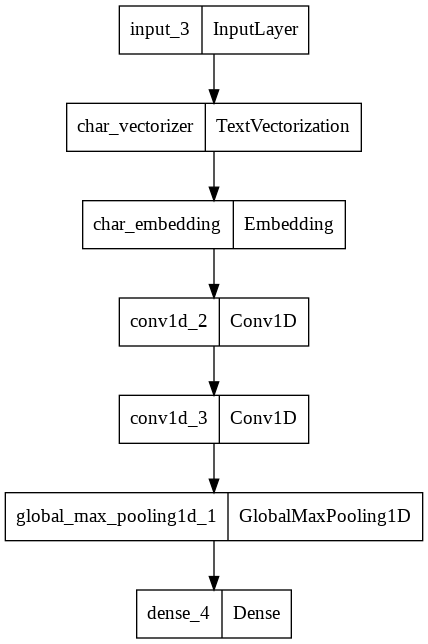

In [70]:
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [71]:
baseline_results

{'accuracy': 72.1832384482987,
 'precison': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1 score': 0.6989250353450294}

# Model 4-Combining pretrained token embeddings + character embeddings to a single model

In [72]:
#1 token input model
token_input=layers.Input(shape=[],dtype=tf.string,name='token_input')
token_embed = tf_hub_embedding_layer(token_input)
token_output=layers.Dense(128,activation='relu')(token_embed)
token_model=tf.keras.Model(inputs=token_input,
                           outputs=token_output)

#2 char input
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)

#concatnate token model and char model
token_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])
#creating the output layers and addition of dropout

combi_drop=layers.Dropout(0.5)(token_concat)
combi_dense=layers.Dense(264,activation='relu')(combi_drop)
final_drop=layers.Dropout(0.5)(combi_dense)
final_output=layers.Dense(num_classes,activation='softmax')(final_drop)

#making model with char and token model
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=final_output,
                       name='model_4_token_and_char_embeddings')

In [73]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

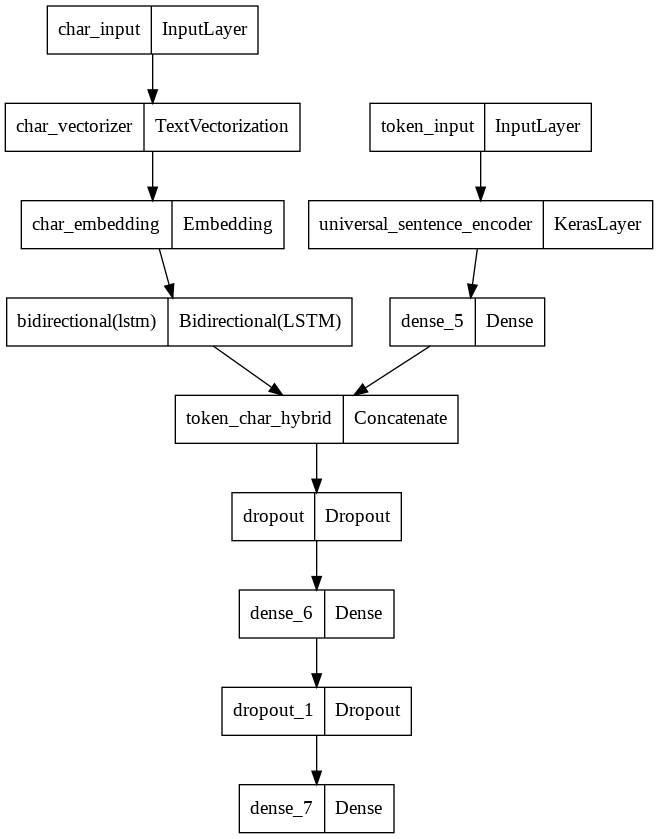

In [74]:
plot_model(model_4)

In [75]:
# Compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
#creating the char datasets for better performance usinfg tf.data
train_char_token_datasets=tf.data.Dataset.from_tensor_slices(((train_sentences,train_char), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_datasets=tf.data.Dataset.from_tensor_slices(((val_sentences,val_char),val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_datasets=tf.data.Dataset.from_tensor_slices(((test_sentences,test_char),test_labes_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:

# Check out training char and token embedding dataset
train_char_token_datasets, val_char_token_datasets

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [78]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_datasets, # train on dataset of token and characters
                              steps_per_epoch=int(0.2 * len(train_char_token_datasets)),
                              epochs=5,
                              validation_data=val_char_token_datasets,
                              validation_steps=int(0.2 * len(val_char_token_datasets)))

Epoch 1/5
1125/1125 [==============================] - 48s 38ms/step - loss: 0.8717 - accuracy: 0.6580 - val_loss: 0.7089 - val_accuracy: 0.7320
Epoch 2/5
1125/1125 [==============================] - 41s 36ms/step - loss: 0.7473 - accuracy: 0.7154 - val_loss: 0.6667 - val_accuracy: 0.7495
Epoch 3/5
1125/1125 [==============================] - 41s 36ms/step - loss: 0.7364 - accuracy: 0.7203 - val_loss: 0.6435 - val_accuracy: 0.7584
Epoch 4/5
1125/1125 [==============================] - 43s 38ms/step - loss: 0.7039 - accuracy: 0.7341 - val_loss: 0.6267 - val_accuracy: 0.7675
Epoch 5/5
1125/1125 [==============================] - 42s 37ms/step - loss: 0.6969 - accuracy: 0.7376 - val_loss: 0.6205 - val_accuracy: 0.7646


In [79]:
model_4.evaluate(val_char_token_datasets)

945/945 [==============================] - 22s 23ms/step - loss: 0.6230 - accuracy: 0.7625


[0.6230055093765259, 0.7624784708023071]

In [80]:
model_4_pred_probs = model_4.predict(val_char_token_datasets)
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 21s 21ms/step


{'accuracy': 76.24784853700515,
 'precison': 0.7593926666817861,
 'recall': 0.7624784853700516,
 'f1 score': 0.7581107115823341}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [81]:
train_df.head()

,target,text,line_number,total_number_of_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


### Creating positional embedding

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64


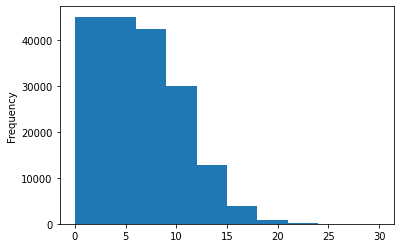

In [82]:
#finding  number of differnt line numbers
tn=train_df.line_number.value_counts()
print(tn)
train_df.line_number.plot.hist(bins=10);

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 17 or less.

In [83]:
#using tf creating the one hot encoded tensors for line number
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=17)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=17)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=17)

In [84]:
train_line_numbers_one_hot.shape

TensorShape([180040, 17])

In [85]:
train_line_numbers_one_hot.dtype

tf.float32

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_number_of_lines, dtype: int64


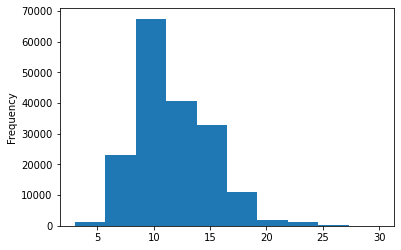

In [86]:
tn=train_df.total_number_of_lines.value_counts()
print(tn)
train_df.total_number_of_lines.plot.hist();


In [87]:

# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_number_of_lines, 98) # a value of 20 covers 98% of sample

20.0

In [88]:
# Useing TensorFlow to create one-hot-encoded tensors of our "total_number_of_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_number_of_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_number_of_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_number_of_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape

TensorShape([180040, 20])

In [89]:
train_total_lines_one_hot.dtype

tf.float32

##Building the embeded model

In [90]:
#token_model
token_inputs=layers.Input(shape=[],dtype=tf.string,name='token_inputs')
token_embedd=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation='relu',name='token_outputs')(token_embedd)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

#char_model
char_inputs=layers.Input(shape=[1,],dtype=tf.string,name='char_inputs')
char_vector=char_vectorizer(char_inputs)
char_embedd=char_embedding(char_vector)
char_bi_lstm=layers.Bidirectional(layers.LSTM(32))(char_embedd)
char_outputs=layers.Dense(128,activation='relu')(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

#line_number_model
line_number_inputs=layers.Input(shape=(17),dtype=tf.float32,name='line_number_inputs')
x=layers.Dense(64,activation='relu')(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,
                                 outputs=x)


#total lines model

total_lines_inputs=layers.Input(shape=(20),dtype=tf.float32,name='total_lines_inputs')
y=layers.Dense(64,activation='relu')(total_lines_inputs)
total_line_model=tf.keras.Model(inputs=total_lines_inputs,
                                outputs=y)

#combining token and char models
combined_embedd=layers.Concatenate(name='token_char_embedding')([token_model.output,
                                                                 char_model.output])
z=layers.Dense(256,activation='relu')(combined_embedd)
z=layers.Dropout(0.5)(z)

#combining the positional embedding with combined token and char embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
# creating the final output layer
output_layer=layers.Dense(5,activation='softmax',name='output_layer')(z)


#putting together the model
model_5=tf.keras.Model(inputs=[token_model.input,
                               char_model.input,
                               line_number_model.input,
                               total_line_model.input],
                       outputs=output_layer)





In [91]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, 290, 25)      1700        ['char_vectorizer[2][0]']  

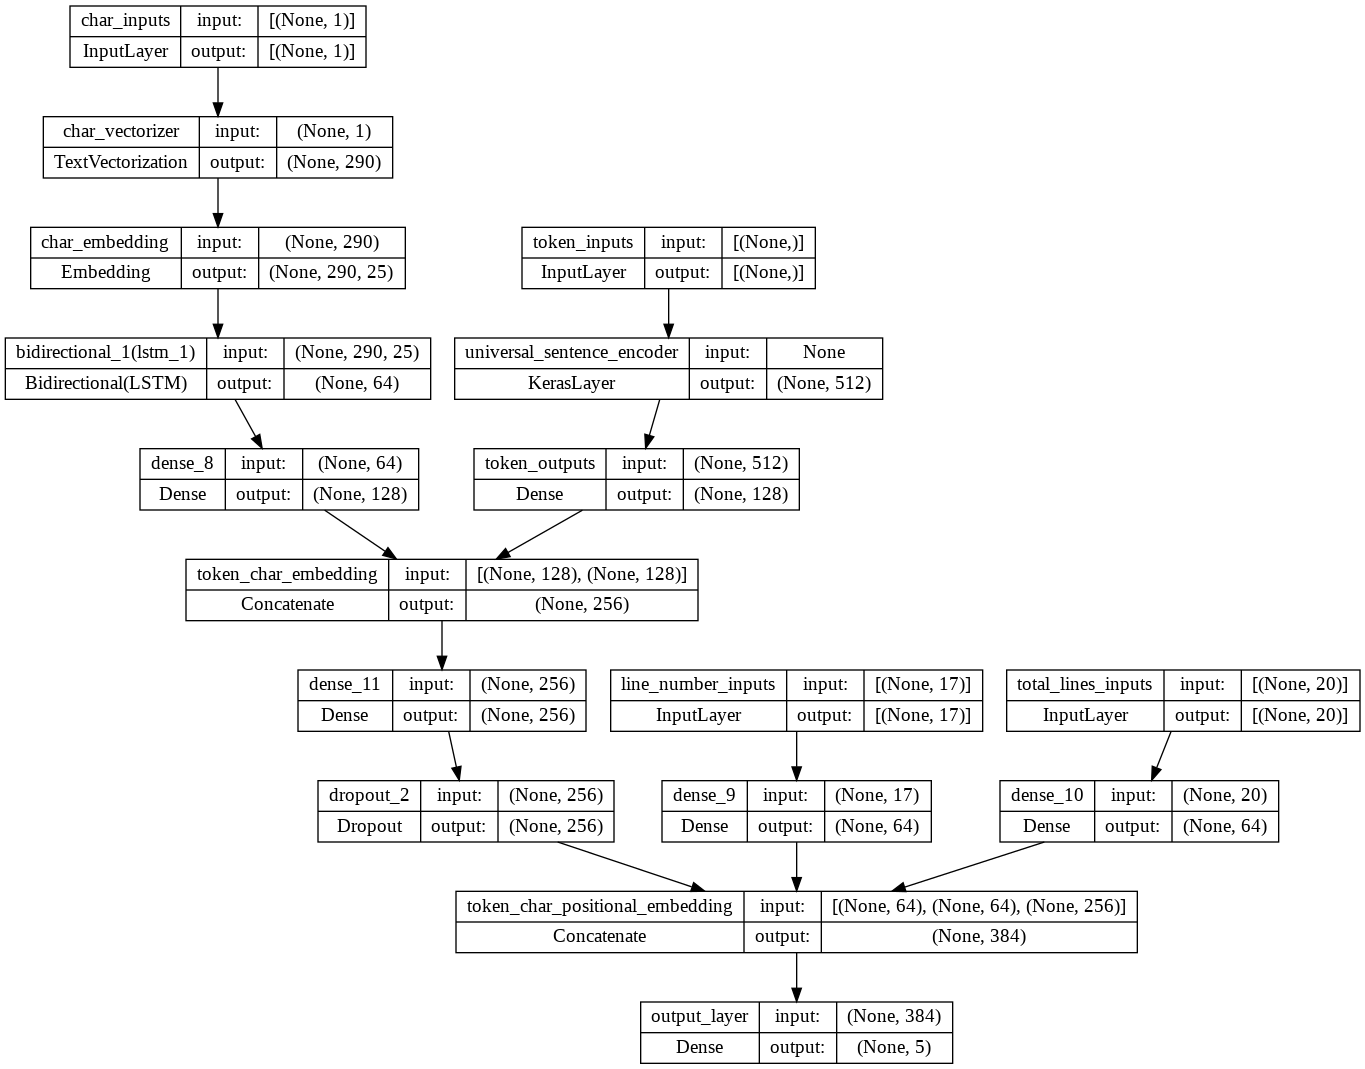

In [92]:
plot_model(model_5,show_shapes=True)

In [93]:

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [94]:
#creating the trainig datasets
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_char,train_line_numbers_one_hot,
                                                                train_total_lines_one_hot))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [95]:
#creating the validation datasets
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_char,val_line_numbers_one_hot,
                                                                val_total_lines_one_hot))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) 
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
#fiting the model  to the datsets
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.2 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.2 * len(val_pos_char_token_dataset)))

Epoch 1/5
1125/1125 [==============================] - 47s 38ms/step - loss: 1.0210 - accuracy: 0.7746 - val_loss: 0.9382 - val_accuracy: 0.8320
Epoch 2/5
1125/1125 [==============================] - 41s 37ms/step - loss: 0.9399 - accuracy: 0.8313 - val_loss: 0.9242 - val_accuracy: 0.8376
Epoch 3/5
1125/1125 [==============================] - 43s 38ms/step - loss: 0.9366 - accuracy: 0.8339 - val_loss: 0.9121 - val_accuracy: 0.8472
Epoch 4/5
1125/1125 [==============================] - 43s 38ms/step - loss: 0.9239 - accuracy: 0.8431 - val_loss: 0.9024 - val_accuracy: 0.8575
Epoch 5/5
1125/1125 [==============================] - 41s 37ms/step - loss: 0.9230 - accuracy: 0.8455 - val_loss: 0.9026 - val_accuracy: 0.8509


In [97]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

945/945 [==============================] - 21s 21ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [98]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.01919766980008,
 'precison': 0.8513667006768065,
 'recall': 0.8501919766980008,
 'f1 score': 0.8469965221726438}

# Model_6-Coustom token embedded Cov1D + Char embedding+positional embedding

In [99]:
#token_model
token_inputs=layers.Input(shape=(1,),dtype=tf.string,name='token_inputs')
text_vectors=text_vectorizer(token_inputs)
token_embedd = token_embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embedd)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
token_outputs=layers.Dense(128,activation='relu',name='token_outputs')(x)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

#char_model
char_inputs=layers.Input(shape=[1,],dtype=tf.string,name='char_inputs')
char_vector=char_vectorizer(char_inputs)
char_embedd=char_embedding(char_vector)
char_bi_lstm=layers.Bidirectional(layers.LSTM(32))(char_embedd)
char_outputs=layers.Dense(128,activation='relu')(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

#line_number_model
line_number_inputs=layers.Input(shape=(17),dtype=tf.float32,name='line_number_inputs')
x=layers.Dense(64,activation='relu')(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,
                                 outputs=x)


#total lines model

total_lines_inputs=layers.Input(shape=(20),dtype=tf.float32,name='total_lines_inputs')
y=layers.Dense(64,activation='relu')(total_lines_inputs)
total_line_model=tf.keras.Model(inputs=total_lines_inputs,
                                outputs=y)

#combining token and char models
combined_embedd=layers.Concatenate(name='token_char_embedding')([token_model.output,
                                                                 char_model.output])
z=layers.Dense(256,activation='relu')(combined_embedd)
z=layers.Dropout(0.5)(z)

#combining the positional embedding with combined token and char embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
# creating the final output layer
output_layer=layers.Dense(5,activation='softmax',name='output_layer')(z)


#putting together the model
model_6=tf.keras.Model(inputs=[token_model.input,
                               char_model.input,
                               line_number_model.input,
                               total_line_model.input],
                       outputs=output_layer)




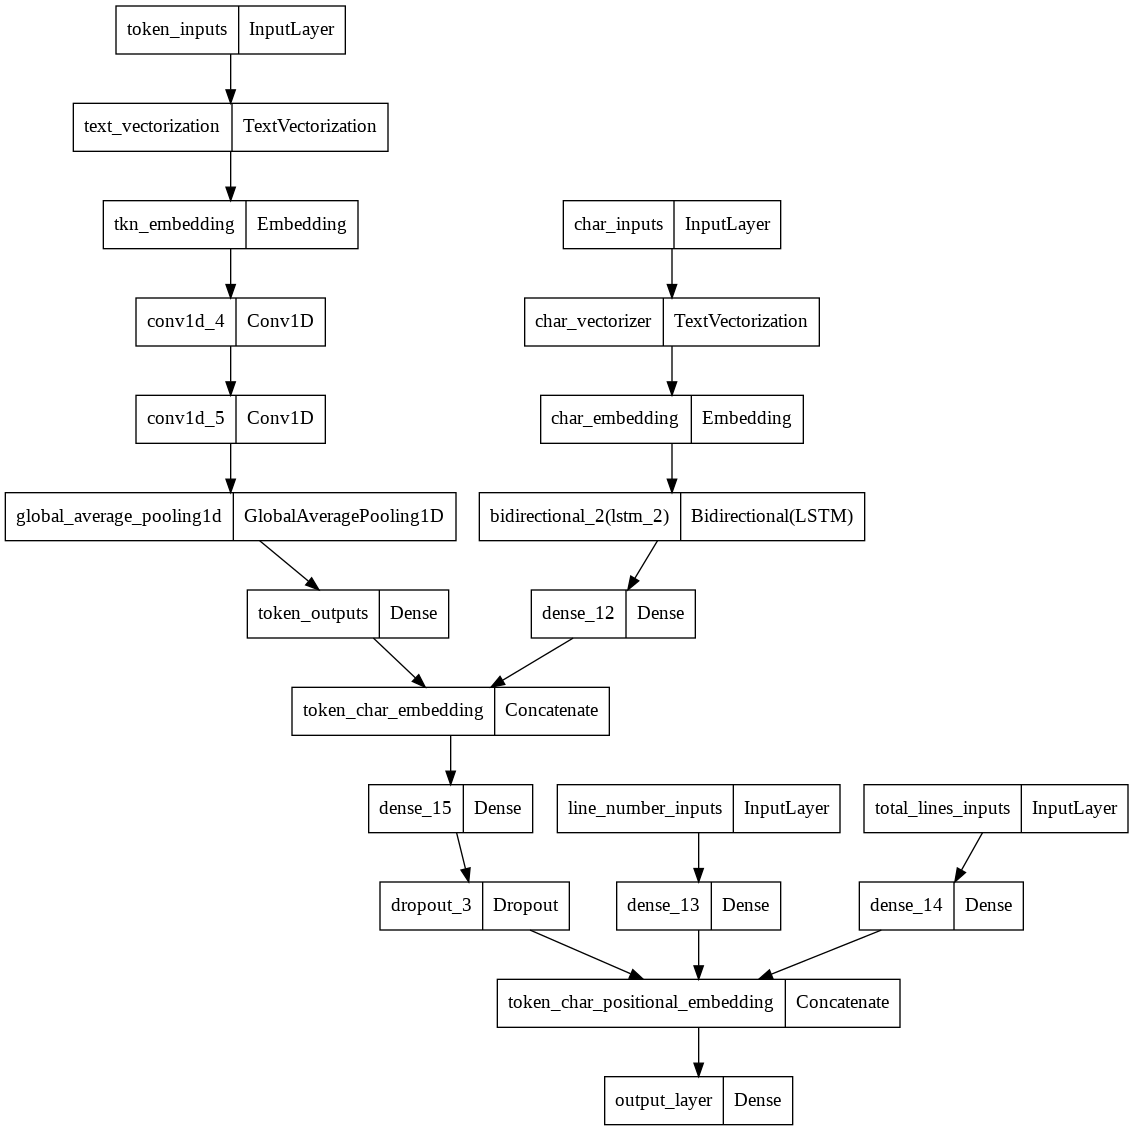

In [100]:
plot_model(model_6)

In [101]:

# Compile 
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     

In [102]:
#fiting the model
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.2 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.2 * len(val_pos_char_token_dataset)))

Epoch 1/5
1125/1125 [==============================] - 43s 35ms/step - loss: 0.9462 - accuracy: 0.8256 - val_loss: 0.8869 - val_accuracy: 0.8543
Epoch 2/5
1125/1125 [==============================] - 39s 35ms/step - loss: 0.8747 - accuracy: 0.8725 - val_loss: 0.8838 - val_accuracy: 0.8578
Epoch 3/5
1125/1125 [==============================] - 40s 35ms/step - loss: 0.8700 - accuracy: 0.8761 - val_loss: 0.8747 - val_accuracy: 0.8616
Epoch 4/5
1125/1125 [==============================] - 38s 34ms/step - loss: 0.8610 - accuracy: 0.8804 - val_loss: 0.8733 - val_accuracy: 0.8624
Epoch 5/5
1125/1125 [==============================] - 38s 34ms/step - loss: 0.8622 - accuracy: 0.8797 - val_loss: 0.8829 - val_accuracy: 0.8614


In [103]:
model_6_pred_probs = model_6.predict(val_pos_char_token_dataset, verbose=1)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

945/945 [==============================] - 13s 12ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [104]:
# Calculating the results
model_6_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 86.02542036276975,
 'precison': 0.8655585889269385,
 'recall': 0.8602542036276976,
 'f1 score': 0.8573816444431355}

# comparing all the model results

In [105]:
# Combining all models results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "char_token_embed": model_4_results,
                                  "pos_char_token_embed": model_5_results,
                                  "Con1D_char_pos_embed": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precison,recall,f1 score
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,82.149477,0.820903,0.821495,0.818209
pretrained_token_embed,75.900305,0.753806,0.759003,0.754283
custom_char_embed_conv1d,72.937905,0.732528,0.729379,0.722581
char_token_embed,76.247849,0.759393,0.762478,0.758111
pos_char_token_embed,85.019198,0.851367,0.850192,0.846997
Con1D_char_pos_embed,86.025420,0.865559,0.860254,0.857382


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


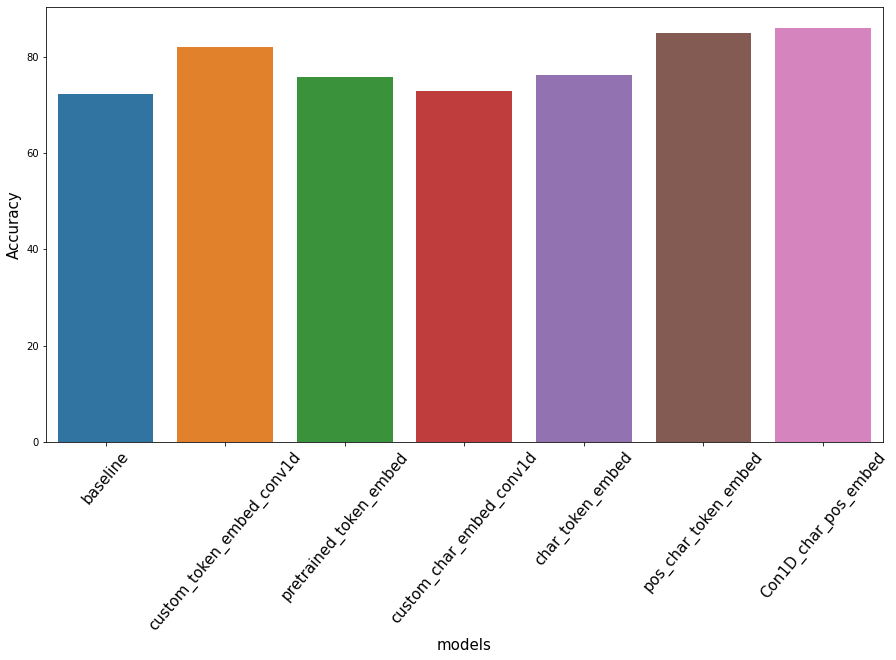

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.xticks(rotation=50,size=15)
sns.barplot(all_model_results.index,all_model_results['accuracy'])
plt.xlabel('models', fontsize=15)
plt.ylabel('Accuracy', fontsize=15);

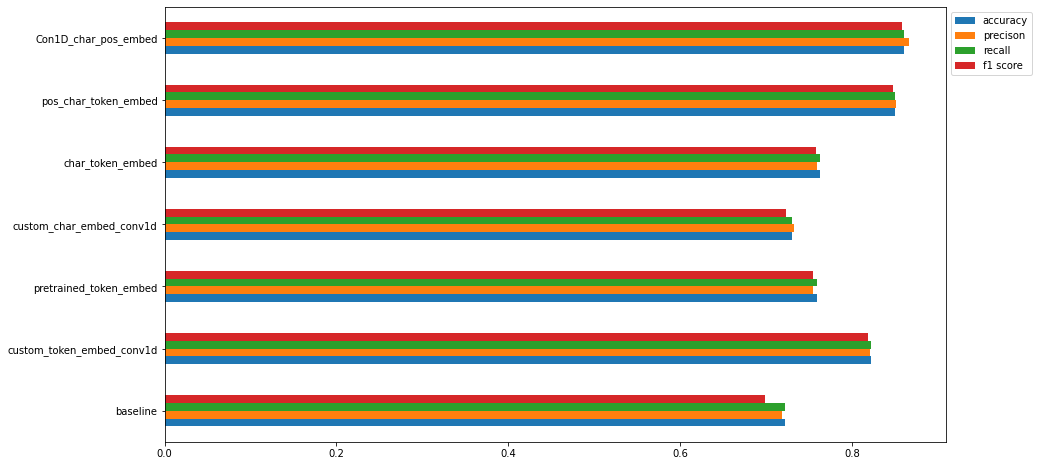

In [107]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind='barh',figsize=(14,8)).legend(bbox_to_anchor=(1.0, 1.0));

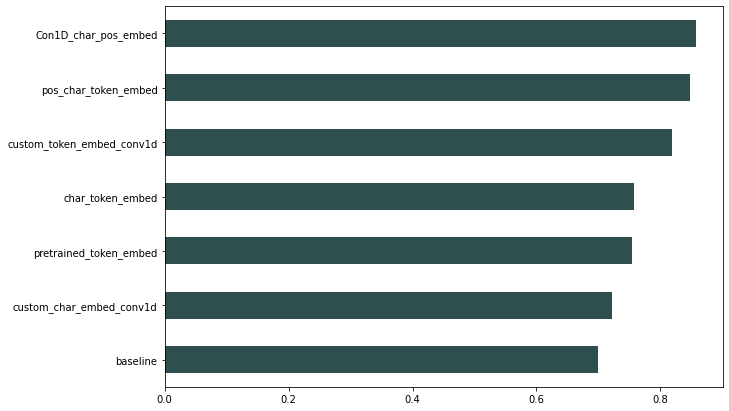

In [108]:
all_model_results.sort_values("f1 score", ascending=True)["f1 score"].plot(kind="barh", figsize=(10, 7),color='darkslategrey');

# saving the best performing model

In [109]:
#model_6.save("/content/drive/MyDrive/tensorflow_models/skimlit_tribrid_model") # model will be saved to path specified by string

In [110]:
# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/tensorflow_models/skimlit_tribrid_model')

In [111]:

# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 13s 13ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [112]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 86.50867205084073,
 'precison': 0.8676754598842913,
 'recall': 0.8650867205084073,
 'f1 score': 0.8621504747553853}

In [113]:

# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_6_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

# Evaluating the model on test Data

In [114]:

# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_char,test_line_numbers_one_hot,
                                                                test_total_lines_one_hot))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labes_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [115]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 [==============================] - 13s 14ms/step


In [116]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 86.19877219180356,
 'precison': 0.8635046822758256,
 'recall': 0.8619877219180355,
 'f1 score': 0.8588665335587782}

# Making sample predictions

In [117]:
import json

In [118]:

# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/Hirann97/tensorflow_deeplearning/main/deep%20learning%20-%20my%20learning%20pathways/skimlit_sample.json

with open("skimlit_sample.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-01-04 12:47:10--  https://raw.githubusercontent.com/Hirann97/tensorflow_deeplearning/main/deep%20learning%20-%20my%20learning%20pathways/skimlit_sample.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9394 (9.2K) [text/plain]
Saving to: ‘skimlit_sample.json’

skimlit_sample.json 100%[===================>]   9.17K  --.-KB/s    in 0s      

2023-01-04 12:47:10 (70.8 MB/s) - ‘skimlit_sample.json’ saved [9394/9394]



[{'abstract': 'The aim of the present systematic review and meta-analysis was to gain further insight into the effects of adherence to Mediterranean Diet (MedD) on risk of overall cancer mortality, risk of different types of cancer, and cancer mortality and recurrence risk in cancer survivors. Literature search was performed using the electronic databases PubMed, and Scopus until 25 August 2017. We included randomized trials (RCTs), cohort (for specific tumors only incidence cases were used) studies, and case-control studies. Study-specific risk ratios, hazard ratios, and odds ratios (RR/HR/OR) were pooled using a random effects model. Observational studies (cohort and case-control studies), and intervention trials were meta-analyzed separately. The updated review process showed 27 studies that were not included in the previous meta-analysis (total number of studies evaluated: 83 studies). An overall population of 2,130,753 subjects was included in the present update. The highest adher

In [119]:
abstracts = pd.DataFrame(example_abstracts)
abstracts
     

,abstract,source,details
0,The aim of the present systematic review and m...,https://pubmed.ncbi.nlm.nih.gov/28954418/,Adherence to Mediterranean Diet and Risk of Ca...
1,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
2,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
3,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
4,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [120]:
from spacy.lang.en import English
nlp=English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe('sentencizer')
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] 
abstract_lines

['The aim of the present systematic review and meta-analysis was to gain further insight into the effects of adherence to Mediterranean Diet (MedD) on risk of overall cancer mortality, risk of different types of cancer, and cancer mortality and recurrence risk in cancer survivors.',
 'Literature search was performed using the electronic databases PubMed, and Scopus until 25 August 2017.',
 'We included randomized trials (RCTs), cohort (for specific tumors only incidence cases were used) studies, and case-control studies.',
 'Study-specific risk ratios, hazard ratios, and odds ratios (RR/HR/OR) were pooled using a random effects model.',
 'Observational studies (cohort and case-control studies), and intervention trials were meta-analyzed separately.',
 'The updated review process showed 27 studies that were not included in the previous meta-analysis (total number of studies evaluated: 83 studies).',
 'An overall population of 2,130,753 subjects was included in the present update.',
 'Th

In [121]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'The aim of the present systematic review and meta-analysis was to gain further insight into the effects of adherence to Mediterranean Diet (MedD) on risk of overall cancer mortality, risk of different types of cancer, and cancer mortality and recurrence risk in cancer survivors.',
  'line_number': 0,
  'total_lines': 12},
 {'text': 'Literature search was performed using the electronic databases PubMed, and Scopus until 25 August 2017.',
  'line_number': 1,
  'total_lines': 12},
 {'text': 'We included randomized trials (RCTs), cohort (for specific tumors only incidence cases were used) studies, and case-control studies.',
  'line_number': 2,
  'total_lines': 12},
 {'text': 'Study-specific risk ratios, hazard ratios, and odds ratios (RR/HR/OR) were pooled using a random effects model.',
  'line_number': 3,
  'total_lines': 12},
 {'text': 'Observational studies (cohort and case-control studies), and intervention trials were meta-analyzed separately.',
  'line_number': 4,
  'tot

In [138]:

# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=17) 
test_abstract_line_numbers_one_hot
     

<tf.Tensor: shape=(13, 17), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0.,

In [139]:

# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(13, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
     

In [124]:
# Split abstract lines into characters
abstract_chars = [split_sen(sentence) for sentence in abstract_lines]
abstract_chars

['T h e   a i m   o f   t h e   p r e s e n t   s y s t e m a t i c   r e v i e w   a n d   m e t a - a n a l y s i s   w a s   t o   g a i n   f u r t h e r   i n s i g h t   i n t o   t h e   e f f e c t s   o f   a d h e r e n c e   t o   M e d i t e r r a n e a n   D i e t   ( M e d D )   o n   r i s k   o f   o v e r a l l   c a n c e r   m o r t a l i t y ,   r i s k   o f   d i f f e r e n t   t y p e s   o f   c a n c e r ,   a n d   c a n c e r   m o r t a l i t y   a n d   r e c u r r e n c e   r i s k   i n   c a n c e r   s u r v i v o r s .',
 'L i t e r a t u r e   s e a r c h   w a s   p e r f o r m e d   u s i n g   t h e   e l e c t r o n i c   d a t a b a s e s   P u b M e d ,   a n d   S c o p u s   u n t i l   2 5   A u g u s t   2 0 1 7 .',
 'W e   i n c l u d e d   r a n d o m i z e d   t r i a l s   ( R C T s ) ,   c o h o r t   ( f o r   s p e c i f i c   t u m o r s   o n l y   i n c i d e n c e   c a s e s   w e r e   u s e d )   s t u d i e s ,   a n d   c a 

In [141]:
%%time
test_abstract_pred_probs = loaded_model.predict(x=(tf.constant(abstract_lines),tf.constant(abstract_chars),test_abstract_line_numbers_one_hot,test_abstract_total_lines_one_hot))
test_abstract_pred_probs

1/1 [==============================] - 1s 846ms/step
CPU times: user 927 ms, sys: 15.9 ms, total: 943 ms
Wall time: 906 ms


array([[0.6593027 , 0.01969943, 0.02199371, 0.2635425 , 0.03546159],
       [0.15356183, 0.01236601, 0.68011415, 0.12065974, 0.03329819],
       [0.05904554, 0.02071354, 0.7676703 , 0.0518376 , 0.10073306],
       [0.05316462, 0.02456963, 0.79752886, 0.04530348, 0.07943349],
       [0.03439568, 0.02905125, 0.77594185, 0.03374296, 0.12686823],
       [0.06270742, 0.02256828, 0.11685385, 0.04117627, 0.7566942 ],
       [0.03391896, 0.03172781, 0.23246165, 0.03466151, 0.66723007],
       [0.04601486, 0.02664257, 0.04543065, 0.03870822, 0.8432037 ],
       [0.04344236, 0.1173756 , 0.03822014, 0.03845152, 0.76251036],
       [0.03058997, 0.0593495 , 0.03616279, 0.02660263, 0.8472951 ],
       [0.12476573, 0.7153917 , 0.03775091, 0.04134934, 0.08074234],
       [0.07584651, 0.7661965 , 0.03300645, 0.03613183, 0.0888187 ],
       [0.03831128, 0.35443243, 0.05612457, 0.03937384, 0.5117579 ]],
      dtype=float32)

In [143]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(13,), dtype=int64, numpy=array([0, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 1, 4])>

In [146]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS']

In [148]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: The aim of the present systematic review and meta-analysis was to gain further insight into the effects of adherence to Mediterranean Diet (MedD) on risk of overall cancer mortality, risk of different types of cancer, and cancer mortality and recurrence risk in cancer survivors.
METHODS: Literature search was performed using the electronic databases PubMed, and Scopus until 25 August 2017.
METHODS: We included randomized trials (RCTs), cohort (for specific tumors only incidence cases were used) studies, and case-control studies.
METHODS: Study-specific risk ratios, hazard ratios, and odds ratios (RR/HR/OR) were pooled using a random effects model.
METHODS: Observational studies (cohort and case-control studies), and intervention trials were meta-analyzed separately.
RESULTS: The updated review process showed 27 studies that were not included in the previous meta-analysis (total number of studies evaluated: 83 studies).
RESULTS: An overall population of 2,130,753 subjects wa

### with the model 6 i had gained the accuracy of 86% which is  near to the 'PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts' paper which is having 90% accuracy. 


*  I had only used 10% of the  whole data and  20% of that in  each batch for Training and validating.

